In [7]:
import os, os.path as osp, numpy as np, logging
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import hgcalhistory
from collections import namedtuple
hgcalhistory.logger.setLevel(logging.INFO)

The factory object is just an iterator, so that you can do `for event in factory:` ...

In [8]:
factory = hgcalhistory.EventFactory(
    'root://cmseos.fnal.gov/'
    '/store/user/klijnsma/hgcal/history/Apr16_history_EminFinePhoton1000_EminFineTrack100000_MuonPt10000'
    )

[qondor|   DEBUG|2020-04-21 19:40:30|utils]: Getting exit code for "xrdfs root://cmseos.fnal.gov/ stat -q IsDir /store/user/klijnsma/hgcal/history/Apr16_history_EminFinePhoton1000_EminFineTrack100000_MuonPt10000"
[qondor|   DEBUG|2020-04-21 19:40:30|utils]: Got exit code 0
[qondor| WARNING|2020-04-21 19:40:30|utils]: Issuing command: xrdfs root://cmseos.fnal.gov/ ls /store/user/klijnsma/hgcal/history/Apr16_history_EminFinePhoton1000_EminFineTrack100000_MuonPt10000
[qondor|    INFO|2020-04-21 19:40:31|utils]: Command exited with status 0 - all good
[hgcalhistory|    INFO|2020-04-21 19:40:33|event]: Initialized factory with 28 root files, 5600 events


Wrapper around the factory object to get just the events we want.
In this case, I selected for events that created a photon inside HGCAL (i.e. vertex of a photon track was in HGCAL)

In [9]:
def filter_events_with_photons(factory, N=None):
    if N: pbar = tqdm(total=N)
    i = 0
    for event in factory:
        if not(N is None) and i == N:
            break
            
        if not event.has_calohits_inEE():
            continue
            
        for track in event.tracks:
            if track.pdgid() == 22:
                x, y, z = event.get_vertex_for_track(track).xyz()
                if hgcalhistory.physutils.in_hgcal(z):
                    yield event
                    i += 1
                    if N: pbar.update(1)

### Event displays

Below is small class that plots an event. It uses two methods to get numpy arrays instead of root objects:

`event.get_hits_columnar`: Returns a numpy array of shape `(n_hits, 9)`, where the 9 columns are:
0. x (cm)
1. y (cm)
2. z (cm)
3. layer number
4. time
5. energy (MeV?)
6. parent track ID
7. Which subdetector it's in (1: EE, 2: Hsc, 3: Hsi, 4: Undetermined)
8. PDG ID

In order to get the PDG ID, the parent track must be found via a for-loop, so this method is pretty slow.

`event.get_tracks_columnar`: Returns a numpy array of shape `(n_tracks, 9)`, where the 9 columns are:
0. x end point (cm) (obtained via ROOT.SimTrack.trackerSurfacePosition())
1. y end point (cm) (obtained via ROOT.SimTrack.trackerSurfacePosition())
2. z end point (cm) (obtained via ROOT.SimTrack.trackerSurfacePosition())
3. x (cm) of the vertex (i.e. begin point)
4. y (cm) of the vertex (i.e. begin point)
5. z (cm) of the vertex (i.e. begin point)
6. PDG ID
7. track ID
8. vertex ID

For both methods, by default any hits/tracks that are fully outside HGCAL are filtered. For `event.get_tracks_columnar`, tracks with `(x, y, z) == (0, 0, 0)` are filtered too.

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 409
# of hits in neg: 87705
# of tracks in pos: 1
# of tracks in neg: 11


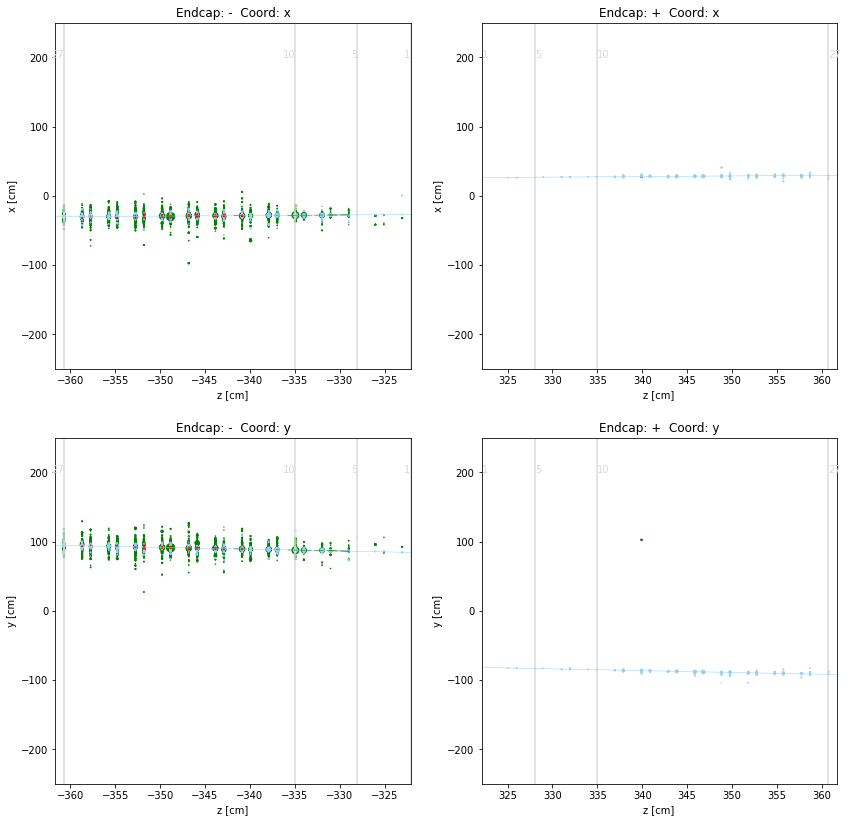

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 409
# of hits in neg: 87705
# of tracks in pos: 1
# of tracks in neg: 11


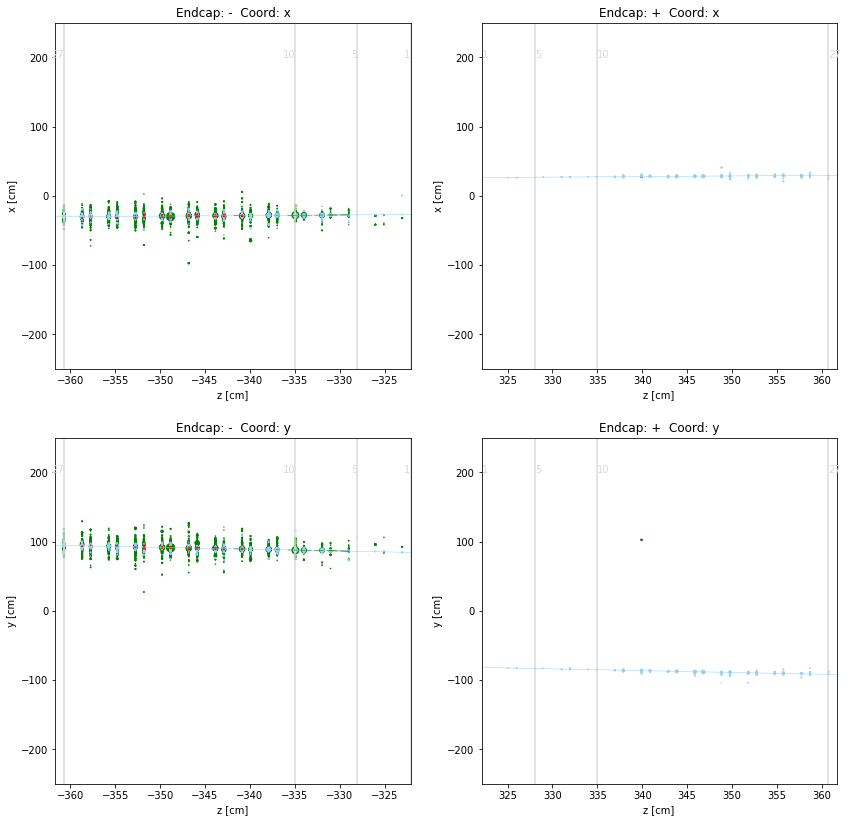

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 21468
# of hits in neg: 94
# of tracks in pos: 6
# of tracks in neg: 1


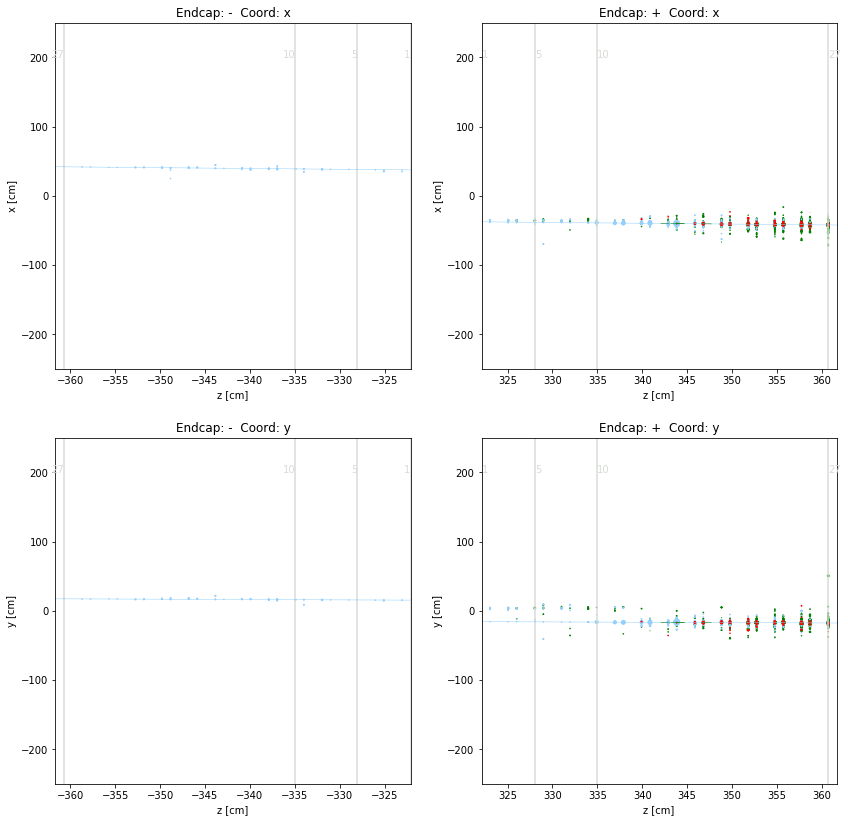

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 21468
# of hits in neg: 94
# of tracks in pos: 6
# of tracks in neg: 1


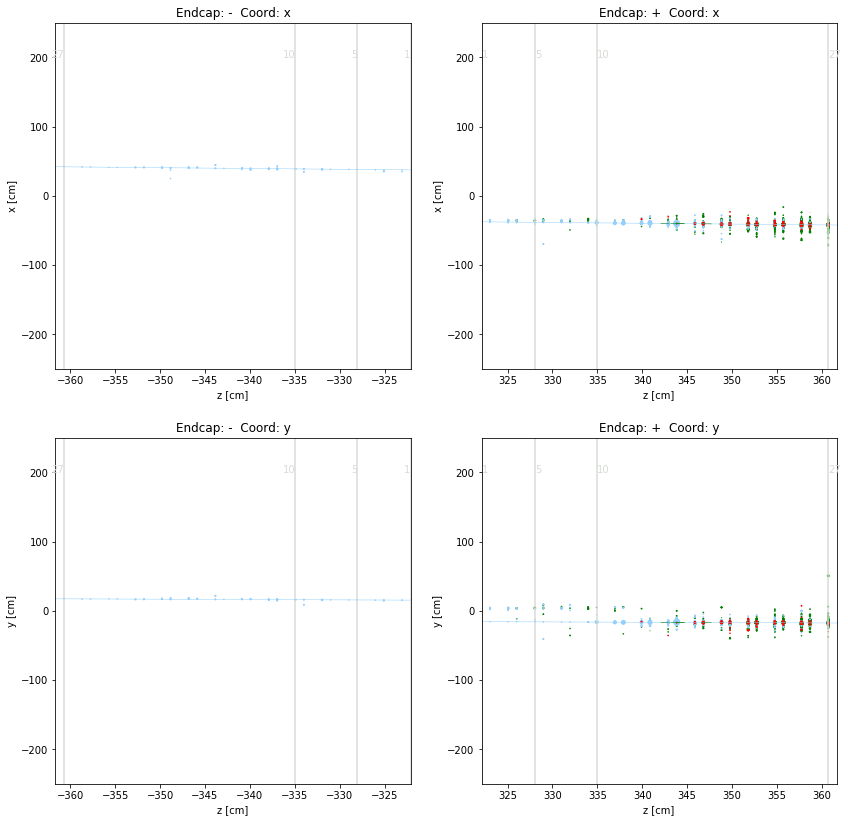

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 910
# of hits in neg: 40943
# of tracks in pos: 1
# of tracks in neg: 7


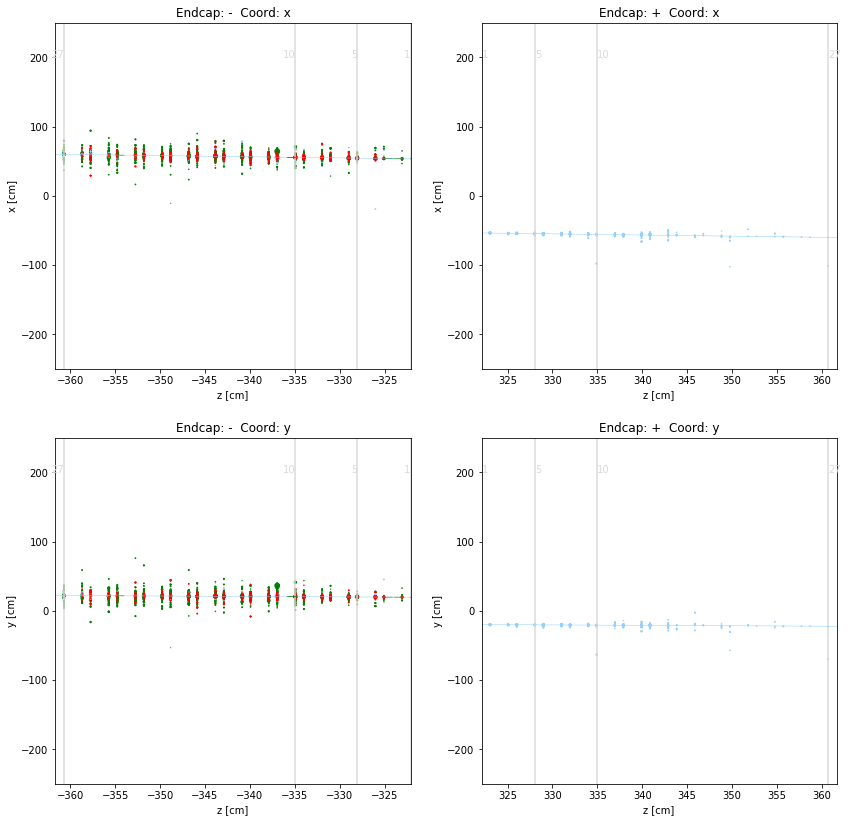

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 951
# of hits in neg: 47560
# of tracks in pos: 2
# of tracks in neg: 9


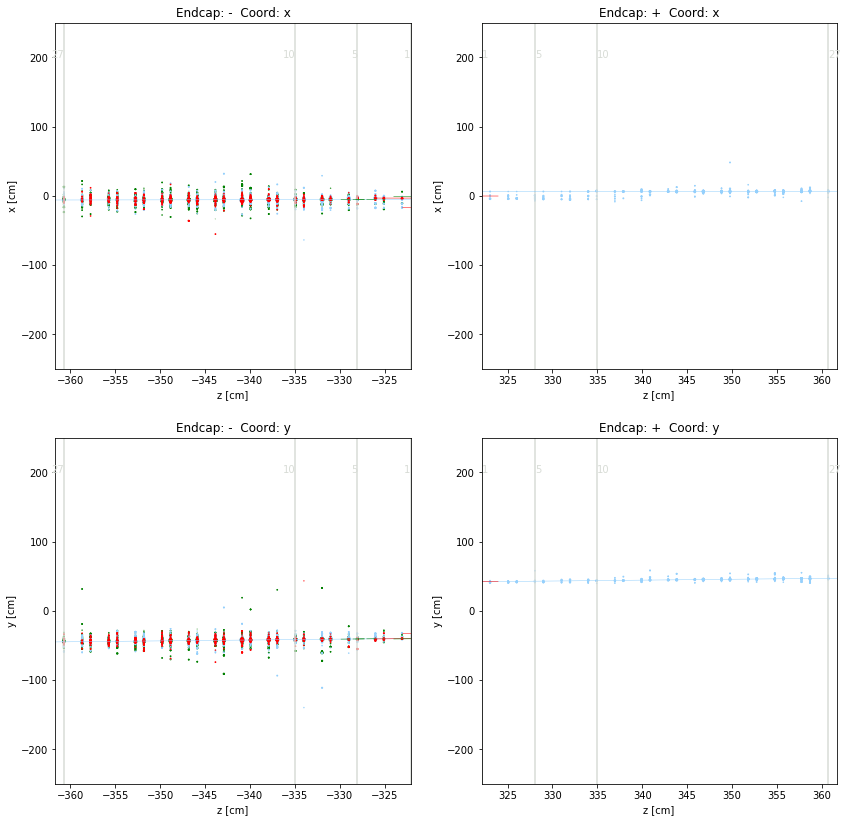

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 18216
# of hits in neg: 2603
# of tracks in pos: 3
# of tracks in neg: 1


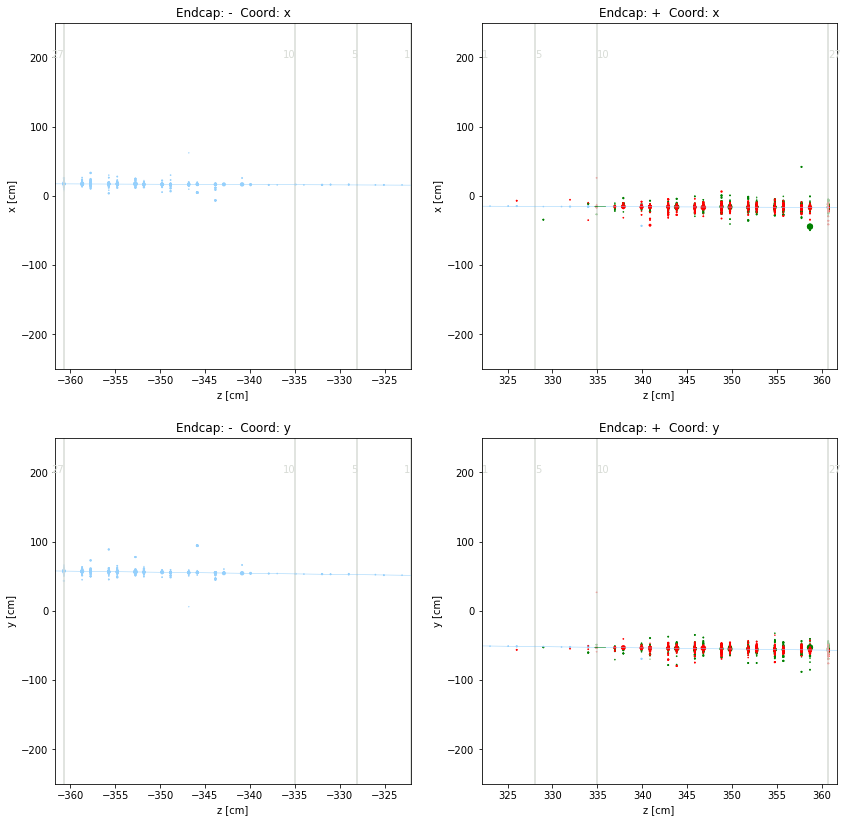

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 3737
# of hits in neg: 96961
# of tracks in pos: 1
# of tracks in neg: 10


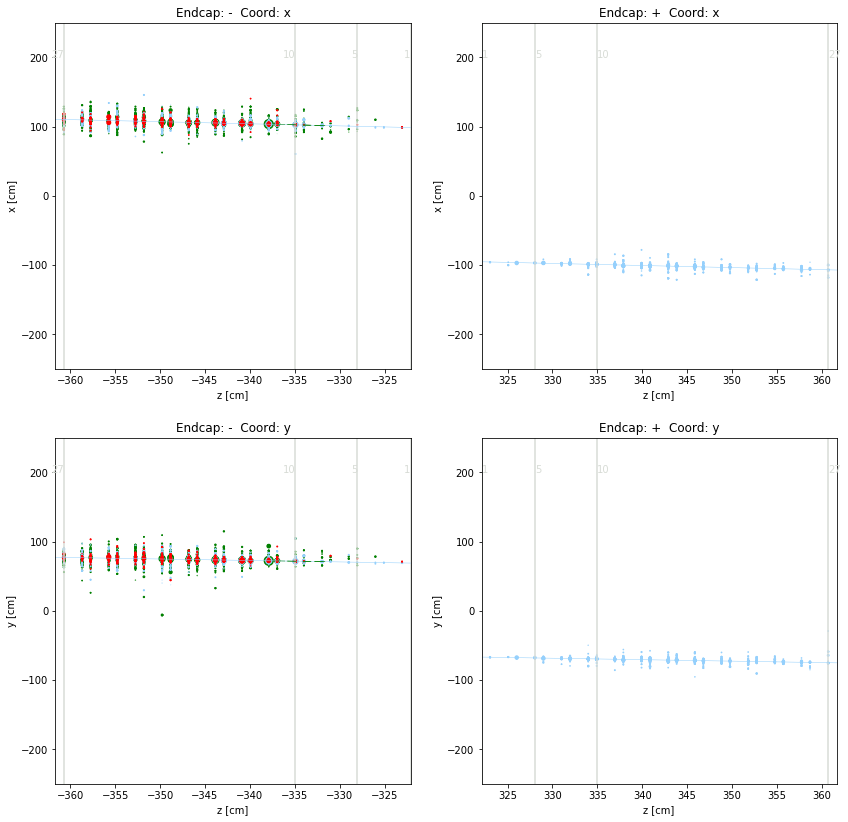

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13. 22.]
# of hits in pos: 3737
# of hits in neg: 96961
# of tracks in pos: 1
# of tracks in neg: 10


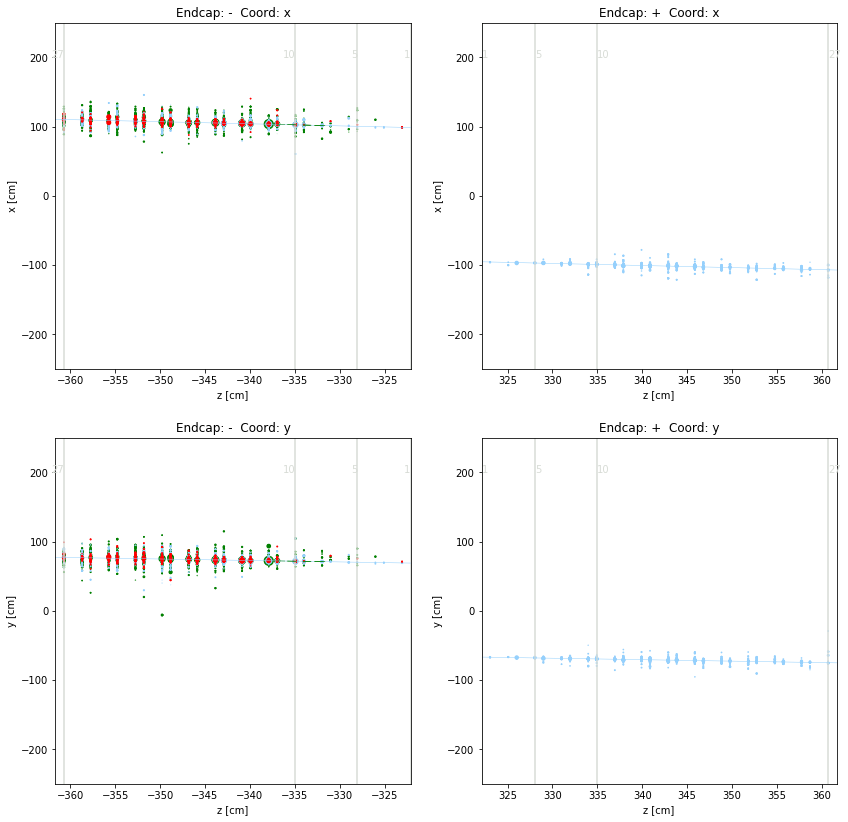

Getting hits with track data...
Getting tracks with vertex data...
pdgids in this event: [11. 13.]
# of hits in pos: 33
# of hits in neg: 1988
# of tracks in pos: 1
# of tracks in neg: 4


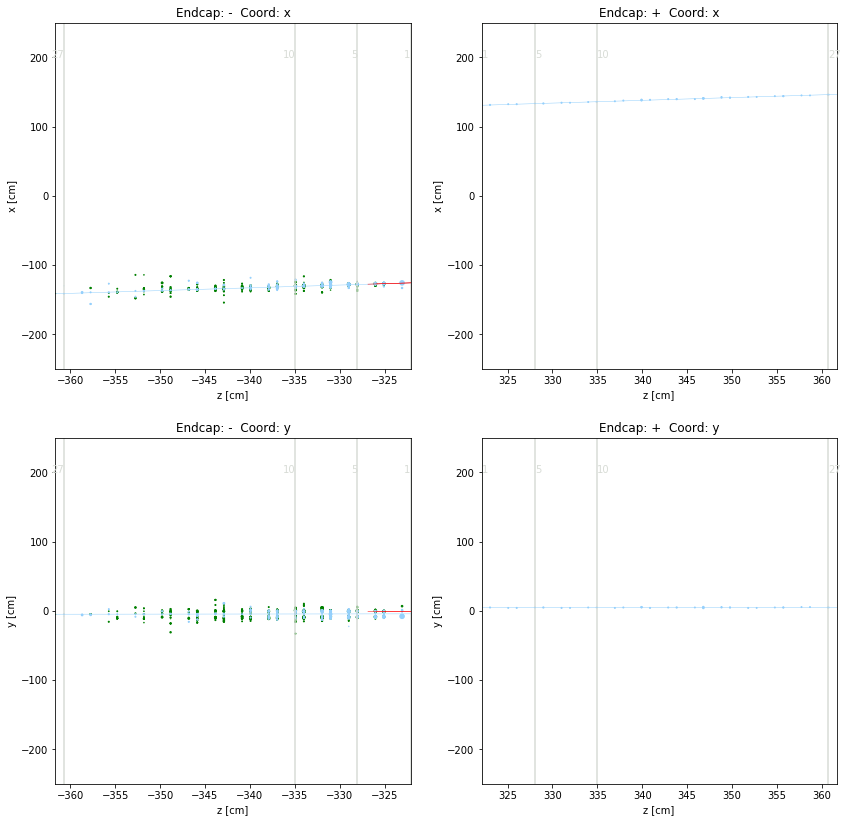

In [10]:
class PlotHits(object):
    PDGID_COLORS = {
        13 : 'xkcd:light blue', # muon
        11 : 'g', # electron
        22 : 'r', # photon
        211 : 'xkcd:orange', # pion
        }
    
    def __init__(self):
        super(PlotHits, self).__init__()
        # Get the minimum and maximum z positions of HGCAL
        self.zmin_pos = min(hgcalhistory.physutils.z_pos_layers)
        self.zmax_pos = max(hgcalhistory.physutils.z_pos_layers)
        self.zmin_neg = min(hgcalhistory.physutils.z_neg_layers)
        self.zmax_neg = max(hgcalhistory.physutils.z_neg_layers)
        self.xmin = -250.
        self.xmax = 250.
    
    def color(self, pdgid):
        """Returns a matplotlib color string for a PDG ID"""
        return self.PDGID_COLORS.get(abs(pdgid), 'xkcd:light grey')
    
    def plot_hits_in_sector(
            self,
            ax,
            hits,
            endcap='+',
            coord='x',
            tracks=None,
            pdgid=None
            ):
        """Makes a plot with hits and tracks for one segment of HGCAL for one coordinate"""
        plt.sca(ax)

        # Plot some straight lines at some layer positions
        for layer in [1, 5, 10, 27 ]:
            z = hgcalhistory.physutils.get_z_for_layer(layer, endcap)
            plt.text(
                z, 0.8*self.xmax, str(layer),
                horizontalalignment='left' if endcap=='+' else 'right',
                color = 'xkcd:light grey'
                )
            ax.plot([z, z], [self.xmin, self.xmax], c='xkcd:light grey')
        
        # Plot tracks
        if not tracks is None:
            for track in tracks:
                ax.plot(
                    [track[5], track[2]],
                    [track[3], track[0]] if coord == 'x' else [track[4], track[1]], # Gets x or y coordinate
                    c = self.color(track[6]),
                    linewidth = 0.5
                    )
        
        # Get pdgids in this event
        pdgids = np.unique(np.abs(hits[:,-1]))
                
        # Plot hits per pdgid
        for pdgid in pdgids:
            hits_this_pdgid = hits[ np.abs(hits[:,-1]) == pdgid ]
            ax.scatter(
                hits_this_pdgid[:,2],
                hits_this_pdgid[:,0] if coord == 'x' else hits_this_pdgid[:,1],
                c = self.color(pdgid),
                s = 10000. * hits_this_pdgid[:,5]
                )
        
        ax.set_title('Endcap: {0}  Coord: {1}'.format(endcap, coord))
        ax.set_xlabel('z [cm]')
        ax.set_ylabel(coord + ' [cm]')
        ax.set_ylim(self.xmin, self.xmax)
        if endcap == '+':
            ax.set_xlim(self.zmin_pos, self.zmax_pos)
        else:
            ax.set_xlim(self.zmin_neg, self.zmax_neg)
        
    def __call__(self, event):
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14))

        print 'Getting hits with track data...'
        hits = event.get_hits_columnar()
        hits_pos = hits[np.logical_and( hits[:,2] > self.zmin_pos, hits[:,2] < self.zmax_pos )]
        hits_neg = hits[np.logical_and( hits[:,2] > self.zmin_neg, hits[:,2] < self.zmax_neg )]
        
        print 'Getting tracks with vertex data...'
        tracks = event.get_tracks_columnar(filter_zero_tracks=False)
        track_z = tracks[:,2]
        vertex_z = tracks[:,5]
        
        # Get tracks per endcap
        tracks_pos = tracks[track_z > 0.]
        tracks_neg = tracks[track_z < 0.]
        
        pdgids = np.unique(np.abs(hits[:,-1]))        
        print 'pdgids in this event: {0}'.format(pdgids)
        print '# of hits in pos:', hits_pos.shape[0]
        print '# of hits in neg:', hits_neg.shape[0]
        print '# of tracks in pos:', tracks_pos.shape[0]
        print '# of tracks in neg:', tracks_neg.shape[0]
        
        self.plot_hits_in_sector(axs[0,0], hits_neg, '-', 'x', tracks=tracks_neg)
        self.plot_hits_in_sector(axs[0,1], hits_pos, '+', 'x', tracks=tracks_pos)
        self.plot_hits_in_sector(axs[1,0], hits_neg, '-', 'y', tracks=tracks_neg)
        self.plot_hits_in_sector(axs[1,1], hits_pos, '+', 'y', tracks=tracks_pos)
        plt.show()

plotmaker = PlotHits()
for event in filter_events_with_photons(factory, 10):
    plotmaker(event)

In [ ]:
a = 4